**Set environment**

In [38]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
library(pheatmap)
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data

**Read total ATAC peaks**

In [2]:
### set file path
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.screened.atac.total.tsv"
fpath = file.path(fdiry, fname)

### read table
dat = read_tsv(fpath, show_col_types = FALSE)

### assign and show
dat_peak_atac_total = dat
print(dim(dat))
head(dat)

[1] 247520      6


Chrom,Start,End,Peak,Assay_Type,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1,10015,10442,chr1:10015-10442,ATAC,ATAC_T
chr1,14253,14645,chr1:14253-14645,ATAC,ATAC_T
chr1,16015,16477,chr1:16015-16477,ATAC,ATAC_T
chr1,17237,17772,chr1:17237-17772,ATAC,ATAC_T
chr1,28903,29613,chr1:28903-29613,ATAC,ATAC_T
chr1,30803,31072,chr1:30803-31072,ATAC,ATAC_T


**Read ATAC peaks screened in each assay**

In [3]:
### set file path
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.screened.fcc.total.tsv"
fpath = file.path(fdiry, fname)

### read table
dat = read_tsv(fpath, show_col_types = FALSE)

### assign and show
dat_peak_atac_fcc = dat
print(dim(dat))
head(dat)

[1] 732434      7


Chrom,Start,End,Peak,Score,Assay_Type,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
chr1,100006256,100006880,chr1:100006256-100006880,-0.01311792,ASTARR,ASTARR_T
chr1,100010437,100010915,chr1:100010437-100010915,-0.80687947,ASTARR,ASTARR_T
chr1,10002087,10003910,chr1:10002087-10003910,-0.34892859,ASTARR,ASTARR_T
chr1,100021298,100021629,chr1:100021298-100021629,-1.03799571,ASTARR,ASTARR_T
chr1,100023727,100023976,chr1:100023727-100023976,-0.19100207,ASTARR,ASTARR_T
chr1,100027983,100029702,chr1:100027983-100029702,-0.18001582,ASTARR,ASTARR_T


## Calculate coverage similarity

In [24]:
dat = dat_peak_atac_fcc
lst = split(dat$Peak, dat$Assay_Type)

lst_vec_txt_peak = lst
table(dat$Assay_Type)


               ASTARR        CRISPRi-Growth         CRISPRi-HCRFF 
               246850                 80288                  1330 
 ENCODE-E2G_Benchmark ENCODE-E2G_Prediction                 LMPRA 
                 3007                 84129                 68420 
                TMPRA                WSTARR 
                 1722                246688 

In [58]:
fun_jaccard = function(txt1, txt2, lst = lst_vec_txt_peak){
    vec1 = lst[[txt1]]
    vec2 = lst[[txt2]]
    num_size1 = length(vec1)
    num_size2 = length(vec2)
    num_size_inter = length(intersect(vec1, vec2))
    num_size_union = length(union(vec1, vec2))
    num_sim_jaccard = num_size_inter / num_size_union
    num_sim_overlap = num_size_inter / min(num_size1, num_size2)
    res  = c(
        txt1, txt2, 
        num_size_inter,
        num_size_union,
        num_sim_jaccard,
        num_sim_overlap
    )
    names(res) = c(
        "V1", "V2", 
        "Intersect", 
        "Union", 
        "Jaccard", 
        "Overlap")
    return(res)
}

In [59]:
lst = lst_vec_txt_peak
vec = names(lst)
dat = expand.grid(vec, vec) #%>% t %>% as.data.frame
dat = apply(dat, 1, function(vec){
    txt1 = vec[1]
    txt2 = vec[2]
    
    res  = fun_jaccard(txt1, txt2)
    return(res)
})
dat = dat %>% t %>% as.data.frame

### assign and show
dat_summary = dat
print(dim(dat))
head(dat)

[1] 64  6


,V1,V2,Intersect,Union,Jaccard,Overlap
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ASTARR,ASTARR,246850,246850,1,1
2,CRISPRi-Growth,ASTARR,80288,246850,0.325250151914118,1
3,CRISPRi-HCRFF,ASTARR,1330,246850,0.00538788738100061,1
4,ENCODE-E2G_Benchmark,ASTARR,3007,246850,0.0121814867328337,1
5,ENCODE-E2G_Prediction,ASTARR,84129,246850,0.340810208628722,1
6,LMPRA,ASTARR,68420,246850,0.277172371885761,1


In [73]:
dat = dat_summary
dat = dat %>% 
    dplyr::mutate(Value = as.double(Jaccard)) %>% 
    dplyr::filter(V1 != "ENCODE-E2G_Prediction", V2 != "ENCODE-E2G_Prediction") %>%
    dplyr::select(V1, V2, Value)

mat = dat %>% 
    tidyr::spread(V2, Value) %>% 
    column_to_rownames("V1") %>% 
    as.matrix

mat_score_pairwise = mat
mat

,ASTARR,CRISPRi-Growth,CRISPRi-HCRFF,ENCODE-E2G_Benchmark,LMPRA,TMPRA,WSTARR
ASTARR,1.000000000,0.325250152,0.005387887,0.01218149,0.27717237,0.006975896,0.999303235
CRISPRi-Growth,0.325250152,1.000000000,0.006883790,0.03504194,0.56851742,0.008708273,0.325367036
CRISPRi-HCRFF,0.005387887,0.006883790,1.000000000,0.04154659,0.01041561,0.261157025,0.005391426
ENCODE-E2G_Benchmark,0.012181487,0.035041938,0.041546590,1.00000000,0.03759497,0.042318713,0.012185383
LMPRA,0.277172372,0.568517425,0.010415610,0.03759497,1.00000000,0.018011350,0.277287080
TMPRA,0.006975896,0.008708273,0.261157025,0.04231871,0.01801135,1.000000000,0.006980477
WSTARR,0.999303235,0.325367036,0.005391426,0.01218538,0.27728708,0.006980477,1.000000000


In [74]:
mat = mat_score_pairwise

paletteLength <- 50
#myColor <- colorRampPalette(c("#abd9e9", "white", "#d73027"))(paletteLength)
#myBreaks <- c(seq(-0.1, 0, length.out=ceiling(paletteLength/2) + 1), 
#              seq(1/paletteLength, 1, length.out=floor(paletteLength/2)))

num      = 1
myColor  = colorRampPalette(c("white", "#d73027"))(paletteLength)
myBreaks = seq(0, num, length.out=paletteLength)

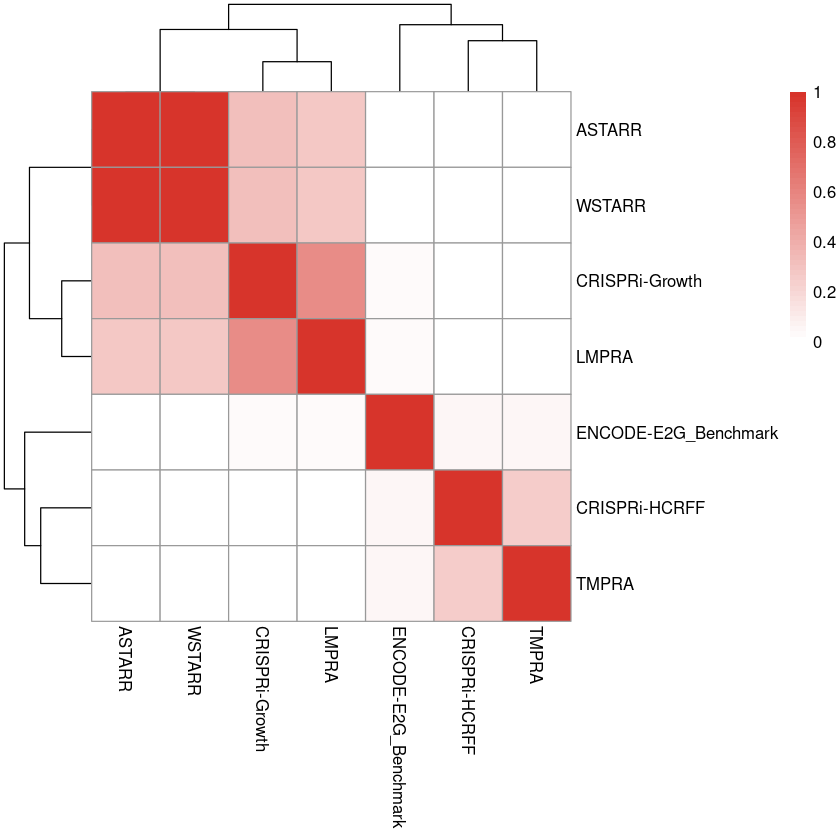

In [75]:
mat = mat_score_pairwise
pheatmap(
    mat,
    color=myColor, 
    breaks=myBreaks
)

In [76]:
dat = dat_summary
dat = dat %>% 
    dplyr::mutate(Value = as.double(Overlap)) %>% 
    dplyr::filter(V1 != "ENCODE-E2G_Prediction", V2 != "ENCODE-E2G_Prediction") %>%
    dplyr::select(V1, V2, Value)

mat = dat %>% 
    tidyr::spread(V2, Value) %>% 
    column_to_rownames("V1") %>% 
    as.matrix

mat_score_pairwise = mat
mat

,ASTARR,CRISPRi-Growth,CRISPRi-HCRFF,ENCODE-E2G_Benchmark,LMPRA,TMPRA,WSTARR
ASTARR,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9999797
CRISPRi-Growth,1.0000000,1.0000000,0.4195489,0.9378118,0.7877814,0.4111498,0.9997758
CRISPRi-HCRFF,1.0000000,0.4195489,1.0000000,0.1300752,0.5406015,0.4751880,1.0000000
ENCODE-E2G_Benchmark,1.0000000,0.9378118,0.1300752,1.0000000,0.8606585,0.1114983,0.9996674
LMPRA,1.0000000,0.7877814,0.5406015,0.8606585,1.0000000,0.7206736,0.9998100
TMPRA,1.0000000,0.4111498,0.4751880,0.1114983,0.7206736,1.0000000,1.0000000
WSTARR,0.9999797,0.9997758,1.0000000,0.9996674,0.9998100,1.0000000,1.0000000


In [77]:
mat = mat_score_pairwise

paletteLength <- 50
#myColor <- colorRampPalette(c("#abd9e9", "white", "#d73027"))(paletteLength)
#myBreaks <- c(seq(-0.1, 0, length.out=ceiling(paletteLength/2) + 1), 
#              seq(1/paletteLength, 1, length.out=floor(paletteLength/2)))

num      = 1
myColor  = colorRampPalette(c("white", "#d73027"))(paletteLength)
myBreaks = seq(0, num, length.out=paletteLength)

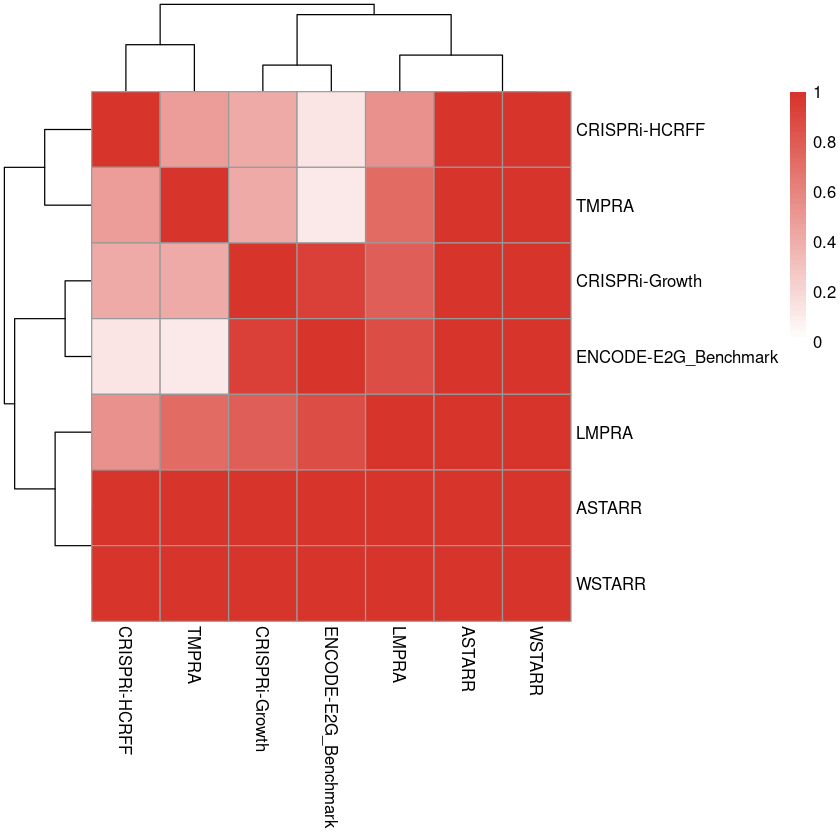

In [78]:
mat = mat_score_pairwise
pheatmap(
    mat,
    color=myColor, 
    breaks=myBreaks
)